In [37]:
!pip install -q kaggle
!pip install heatmapz
!pip install shap

     |████████████████████████████████| 371 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509237 sha256=b3e1632a46eea45f7808491f2daa444e42926d5254904425e7972ccf77abeec1
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
#import your own kaggle.json file
from google.colab import files
files.upload()

In [1]:
#create a kaggle folder
!mkdir ~/.kaggle

#copy your kaggle.json file to this new folder
!cp kaggle.json ~/.kaggle/

#change permissions on kaggle json
!chmod 600 ~/.kaggle/kaggle.json

#download Credit Card Fraud Detection dataset from kaggle
!kaggle datasets download -d mlg-ulb/creditcardfraud

#unzip dataset
!unzip creditcardfraud.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from heatmap import heatmap, corrplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import xgboost as xgb
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from random import seed
seed(122)

In [2]:
def split_train_test_stratified(df, test_percentage=0.2):

  test_percentage = 0.2
  class_percentage = (df['Class'].value_counts()/df.shape[0])

  n_rows_class_0 = df.shape[0]*test_percentage*class_percentage[0]
  n_rows_class_0 = round(n_rows_class_0)

  n_rows_class_1 = df.shape[0]*test_percentage*class_percentage[1]
  n_rows_class_1 = round(n_rows_class_1)

  df_class_0 = df[df['Class'] == 0].copy()
  df_class_1 = df[df['Class'] == 1].copy()

  df_test = df_class_0[:n_rows_class_0].copy()
  df_test = pd.concat([df_test, df_class_1[:n_rows_class_1].copy()])

  df_train = df_class_0[n_rows_class_0:].copy()
  df_train = pd.concat([df_train, df_class_1[n_rows_class_1:].copy()])

  return (df_train, df_test)

def density_plot(df, columns, target, n_columns=2):
  n_rows = int(np.ceil(len(columns)/n_columns))
  plt.figure()
  fig, ax = plt.subplots(n_rows, n_columns,figsize=(30,40));

  for i, column in enumerate(columns):
      plt.subplot(n_rows, n_columns, i+1)
      for target_class in df[target].unique():
        df_target = df.loc[df[target] == target_class]
        sns.kdeplot(df_target[column], bw_method=0.5)
      plt.title(column, fontsize=16)
      plt.xlabel('', fontsize=16)
      locs, labels = plt.xticks()
      plt.tick_params(axis='both', which='major', labelsize=16)
      sns.despine(left=True, right=True)
      fig.tight_layout(pad=5.0)
      plt.grid()
  plt.show()

def plot_xgb_learning_curve(model, metric, label, title):
  results = model.evals_result()
  epochs = len(results['validation_0'][metric])
  x_axis = range(0, epochs)

  fig, ax = plt.subplots()
  ax.plot(x_axis, results['validation_0'][metric], label='Train')
  ax.plot(x_axis, results['validation_1'][metric], label='Val')
  ax.legend()
  plt.ylabel(label)
  plt.title(title)
  sns.despine(left=True, right=True)
  plt.show()

def plot_confusion_matrix(y, y_pred, target_names):
  
  cm = confusion_matrix(y, y_pred, labels=np.unique(y))
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  acc_classes = cmn.diagonal()
  for i, acc in enumerate(acc_classes):
    print(f'Class {target_names[i]} Accuracy: {acc:.2f}')

  ax = sns.heatmap(cmn, annot=True, fmt='.2f', cmap=plt.cm.Blues, xticklabels=target_names, yticklabels=target_names)
  ax.set_title('Confusion Matrix')
  sns.despine(left=True, right=True)
  plt.show()

def plot_roc_curve(y, y_pred, title):
  fpr, tpr, thresholds = roc_curve(y, y_pred)
  roc_auc = auc(fpr, tpr)

  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]
  print("Threshold value is:", optimal_threshold)

  plt.plot(fpr, tpr, color='orange', label = 'AUC = %0.2f' % roc_auc)
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend()
  sns.despine(left=True, right=True)
  plt.show()

def plot_binary_balanced_accuracy_threshold(y, y_proba):
  acc_bal_list = []

  acc_by_class_0 = []
  acc_by_class_1 = []

  thresholds = np.arange(0.0, 1.0, 0.001)
  for threshold in thresholds:
    y_pred = list(map(lambda x: int(x > threshold), y_proba))
    acc_bal = balanced_accuracy_score(y, y_pred)
    acc_bal_list.append(acc_bal)

    cm = confusion_matrix(y, y_pred, labels=np.unique(y))
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    acc_classes = cmn.diagonal()
    acc_by_class_0.append(acc_classes[0])
    acc_by_class_1.append(acc_classes[1])

  ax = sns.lineplot(x=thresholds, y=acc_bal_list)
  ax.set_title('Balanced Accuracy by threshold')
  ax.set_xlabel('Thresholds')
  ax.set_ylabel('Balanced Accuracy')
  sns.despine(left=True, right=True)
  plt.show()

  sns.lineplot(x=thresholds, y=acc_by_class_0)
  ax = sns.lineplot(x=thresholds, y=acc_by_class_1)
  ax.set_title('Class Accuracy by threshold')
  ax.set_xlabel('Thresholds')
  ax.set_ylabel('Balanced Accuracy')
  sns.despine(left=True, right=True)
  plt.legend(title='Class', loc='lower right', labels=['0', '1'])
  plt.show()

def plot_model_metrics(model, X, y, threshold=0.5):

  y_proba = model.predict_proba(X)
  y_proba = y_proba[:,1]

  y_pred = list(map(lambda x: int(x > threshold), y_proba)) 

  target_names = np.unique(y)
  target_names = list(map(str, target_names))

  print(classification_report(y, y_pred, target_names=target_names))

  acc_bal = balanced_accuracy_score(y, y_pred)
  print(f'Balanced Accuracy: {acc_bal}')

  plot_confusion_matrix(y, y_pred, target_names)

  plot_roc_curve(y, y_pred, '(ROC) Curve with threshold')
  plot_roc_curve(y, y_proba, '(ROC) Curve with probability')

  plot_binary_balanced_accuracy_threshold(y, y_proba)

In [3]:
df = pd.read_csv('creditcard.csv')
df = df.sample(frac=1)

In [4]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
76881,56784.0,-2.561709,-8.008907,-1.230862,0.472935,-3.990558,0.946299,1.055009,-0.293732,-1.291127,0.417962,0.278458,-0.245165,-0.027478,-0.282104,-1.171420,-0.168614,0.680351,0.912692,-0.089647,3.827740,0.914725,-1.486354,-1.777776,0.075858,-0.496771,-0.457608,-0.319387,0.374883,2077.24,0
174872,122108.0,-0.870414,0.185525,-0.468996,-2.666051,0.359332,0.106106,0.464085,0.313484,-1.695923,-0.138007,-0.259372,-0.525813,0.321713,0.254958,-0.972044,1.764107,-0.656315,-0.260115,0.447639,-0.050983,0.547636,1.275098,-0.336641,-0.239139,0.412934,-0.031102,-0.140118,0.014822,95.65,0
132757,80100.0,1.161069,-1.003908,0.991018,-0.688513,-1.512645,-0.060871,-1.187889,0.245557,-0.538249,0.733672,1.623368,-0.294613,-0.765415,-0.009410,0.761511,1.374925,0.214290,-0.746451,0.064708,0.120323,0.498559,1.214217,-0.100161,0.244356,0.243335,-0.052513,0.033374,0.022367,69.99,0
158585,111484.0,1.464489,-0.229534,0.010791,3.938706,-0.103764,0.910277,-0.428429,0.169273,0.520156,1.137670,1.439728,-2.140138,1.735844,1.577654,-1.438593,1.612904,-0.613688,0.959044,-1.867609,0.125529,0.212476,0.368947,0.073519,0.677446,-0.393765,-0.118271,-0.064374,-0.005134,203.20,0
155241,104885.0,1.949382,-0.249896,-0.101073,0.461500,-0.705190,-0.546252,-0.693415,0.004192,2.475686,-0.401978,1.861091,-1.746461,0.754337,1.883822,-0.284364,0.401871,-0.091364,0.856704,-0.090203,-0.335538,-0.220663,-0.328862,0.374101,-0.066656,-0.462697,-0.985154,0.023102,-0.044237,2.12,0


In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
#count duplicated rows
df.duplicated().sum()

1081

In [7]:
#drop druplicated rows keeping the last occurrence
df = df.drop_duplicates(keep='last')

In [8]:
#Count null values for each column
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
#Split data from train and test
df_train, df_test = split_train_test_stratified(df)

In [10]:
df_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000
mean,94747.662428,0.005363,-0.006163,0.003748,-0.002516,-0.000344,-0.002426,0.003726,0.000632,-0.000050,-0.003001,-0.000313,0.001691,-0.001450,-0.000770,0.001044,0.000072,-0.000838,0.001035,0.001451,-0.000027,-0.000488,-0.001753,0.000170,0.000221,0.001056,-0.000056,0.001345,0.000866,88.895228,0.001665
std,47503.028982,1.951721,1.654860,1.508008,1.412901,1.383733,1.333280,1.231201,1.171427,1.093967,1.076552,1.019536,0.995279,0.994290,0.953248,0.915539,0.874096,0.844146,0.837527,0.814208,0.779462,0.723652,0.724760,0.632697,0.606053,0.521950,0.482602,0.398834,0.329354,254.375753,0.040775
min,0.000000,-56.407510,-72.715728,-48.325589,-5.519697,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,-24.588262,-4.568390,-18.683715,-5.791881,-19.214325,-4.391307,-13.563273,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.824849,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54194.500000,-0.915689,-0.600543,-0.884280,-0.850117,-0.693083,-0.769441,-0.551359,-0.208849,-0.642907,-0.536373,-0.762937,-0.404647,-0.649324,-0.425740,-0.581948,-0.468629,-0.484759,-0.498444,-0.454720,-0.211577,-0.228579,-0.544414,-0.162279,-0.354547,-0.316614,-0.327415,-0.070750,-0.052882,5.600000,0.000000
50%,84573.500000,0.020425,0.062878,0.182012,-0.020851,-0.055362,-0.275742,0.041783,0.021475,-0.050813,-0.094910,-0.033257,0.140323,-0.015478,0.049726,0.049265,0.066132,-0.066717,-0.002379,0.004742,-0.062506,-0.029612,0.004601,-0.011352,0.040833,0.017624,-0.052570,0.001365,0.011284,22.000000,0.000000
75%,139276.000000,1.314884,0.797846,1.026225,0.740784,0.610156,0.395564,0.571678,0.324551,0.596385,0.449005,0.739740,0.618276,0.661170,0.491205,0.650468,0.522109,0.397949,0.501144,0.459695,0.133248,0.186144,0.526426,0.147876,0.439797,0.351765,0.239932,0.090789,0.078145,78.000000,0.000000
max,172788.000000,2.451888,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226980 entries, 67679 to 263877
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    226980 non-null  float64
 1   V1      226980 non-null  float64
 2   V2      226980 non-null  float64
 3   V3      226980 non-null  float64
 4   V4      226980 non-null  float64
 5   V5      226980 non-null  float64
 6   V6      226980 non-null  float64
 7   V7      226980 non-null  float64
 8   V8      226980 non-null  float64
 9   V9      226980 non-null  float64
 10  V10     226980 non-null  float64
 11  V11     226980 non-null  float64
 12  V12     226980 non-null  float64
 13  V13     226980 non-null  float64
 14  V14     226980 non-null  float64
 15  V15     226980 non-null  float64
 16  V16     226980 non-null  float64
 17  V17     226980 non-null  float64
 18  V18     226980 non-null  float64
 19  V19     226980 non-null  float64
 20  V20     226980 non-null  float64
 21  V21   

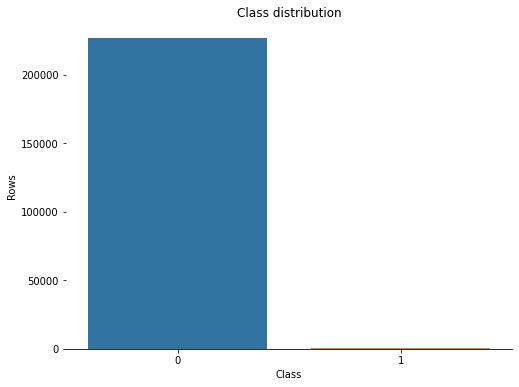

In [12]:
data = df_train['Class'].value_counts().reset_index()

plt.figure(figsize=(8,6))

ax = sns.barplot(x='index', y='Class', data=data)
ax.set_title('Class distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Rows')

sns.despine(left=True, right=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


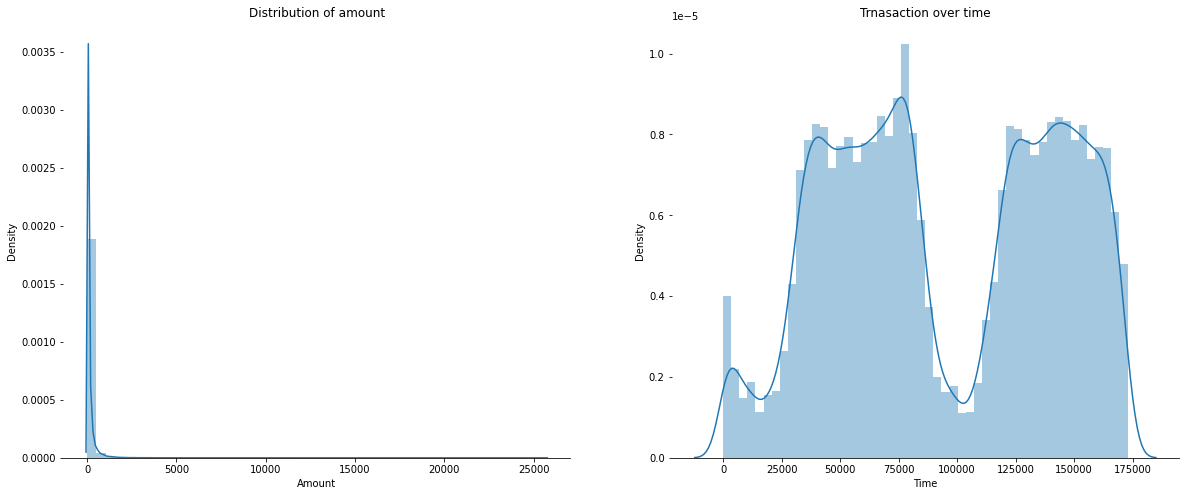

In [13]:
fig,axs=plt.subplots(1,2,figsize=(20,8))

sns.distplot(df_train['Amount'],ax=axs[0])
axs[0].set_title("Distribution of amount")

sns.distplot(df_train['Time'],ax=axs[1])
axs[1].set_title("Trnasaction over time")

sns.despine(left=True, right=True)
plt.show()

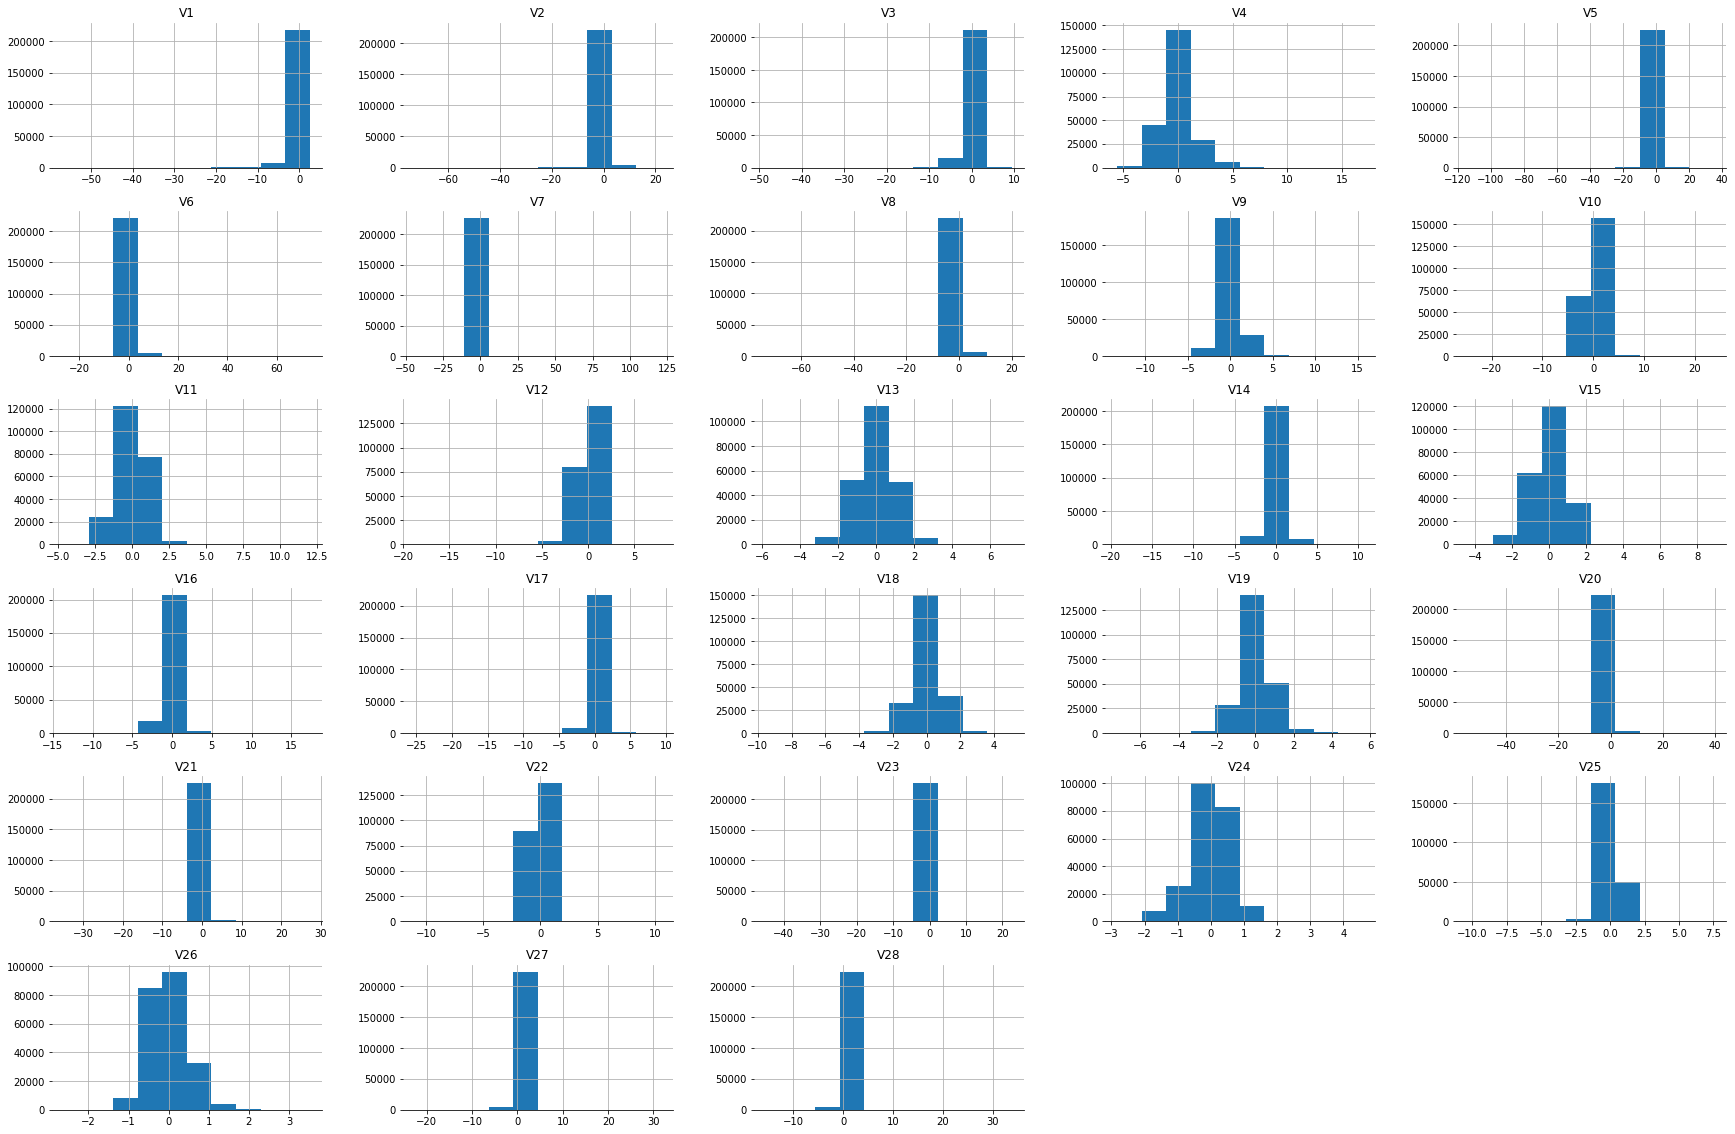

In [14]:
pca_columns = df.columns.to_list()[1:29]

df_train[pca_columns].hist(bins=10, figsize=(30, 20))
sns.despine(left=True, right=True)
plt.show()

<Figure size 432x288 with 0 Axes>

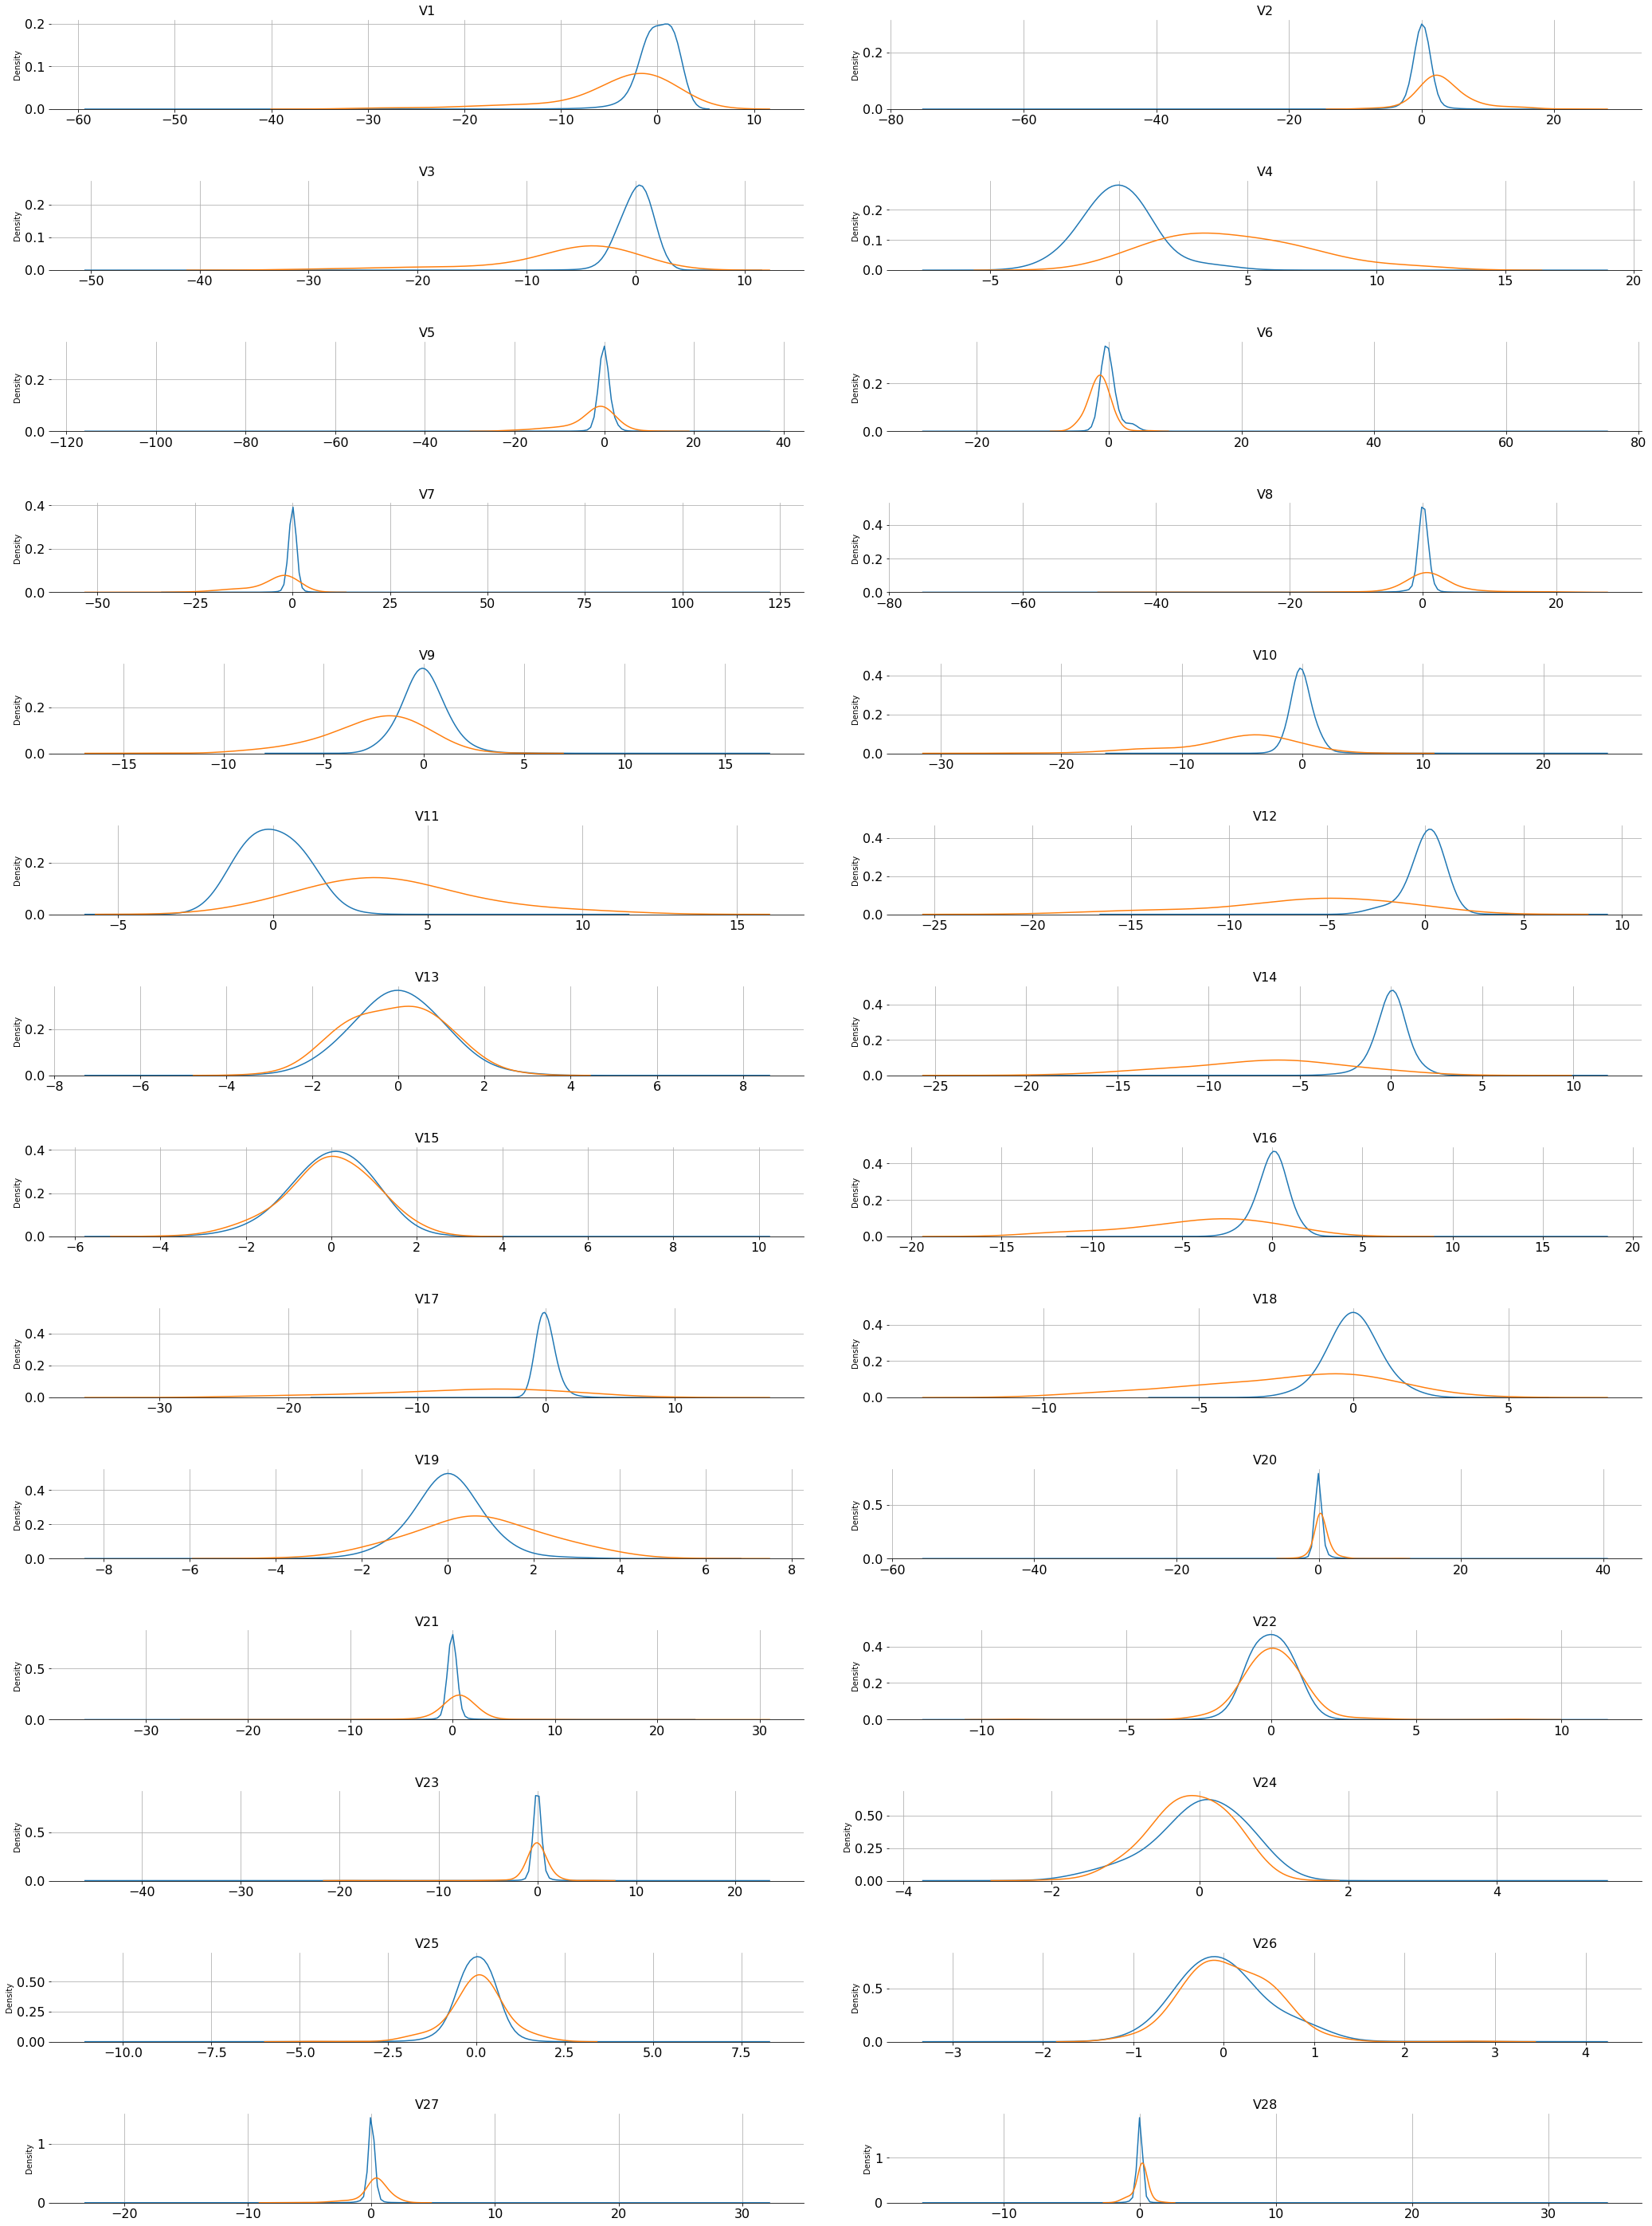

In [15]:
density_plot(df_train, pca_columns, 'Class')

There are a few features that are able to better detach those two classes:

V1, V2, V3, V4, V5, V7, V8, V9, V10, V11, V12, V14, V16, V17, V18, V19, V21, V23, V27

As a hypothesis, it may be helpful for feature selection in our model, if our base line does not perform well

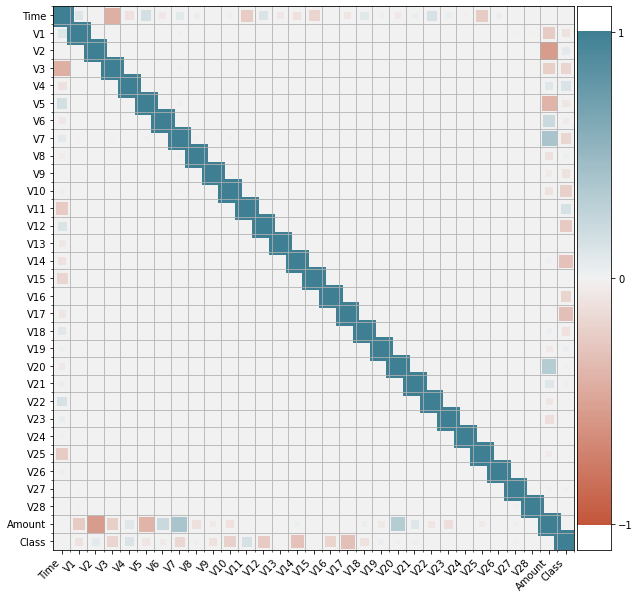

In [16]:
plt.figure(figsize=(10, 10))
corrplot(df_train.corr(), size_scale=500);

At this coorelation matrix, there are a few features there are more correlated to the interested class:

V1, V2, V3, V4, V5, V6, V7, V9, V10, V11, V12, V14, V16, V17, V18

The 'Time' feature will not be relevant for our model since it only counts the interval of each request, and we are not able to feature engineering with others transactions by the fact that there is no ID column on the dataset.

Also we must scaler the 'Amount' feature, due to the difference in its magnitude in relation to the rest of the set. At first let's use MinMaxScaler, in that way, we will keep the distribution of our data, including outliers.

In [17]:
#Split train and validation
train_df, val_df = split_train_test_stratified(df_train.copy())

X_train = train_df
y_train = X_train.pop('Class')

X_val = val_df
y_val = X_val.pop('Class')

In [18]:
#Feature scale Amount
scaler = MinMaxScaler()

X_train['Amount'] = scaler.fit_transform(X_train[['Amount']].values)

#Remove Time feature
X_train = X_train.drop(['Time'], axis=1)

#scale val dataset
X_val['Amount'] = scaler.transform(X_val[['Amount']].values)
X_val = X_val.drop(['Time'], axis=1)

In [19]:
X_tsne_2d = TSNE(n_components=2, learning_rate='auto',  init='random', random_state=42).fit_transform(X_train.values)

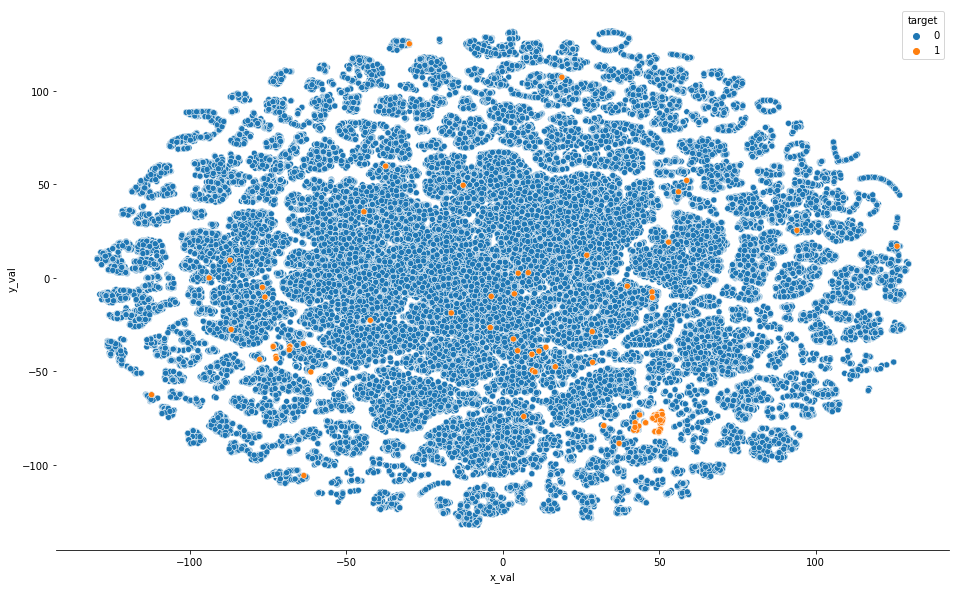

In [20]:
train_scaled_tsne = pd.DataFrame({
    'x_val': X_tsne_2d[:,0],
    'y_val': X_tsne_2d[:,1],
    'target': y_train
})

plt.figure(figsize=(16,10))
sns.scatterplot(
    x='x_val',
    y='y_val',
    hue="target",
    data=train_scaled_tsne,
    legend="full",
)
sns.despine(left=True, right=True)
plt.show()

With T-SNE we are able to see our N dimensions data on a 2D visualization. Despite the significant dots of Fraud (1) are pretty mixes with Non_fraud (0), there are a nice cluster in the center, that may be a nice way to optimize out model.

From here, I see 3 hypothesis to work with
  - Logistic Regression Model, since all features are continuous. The drawback if the expensive cost to calculete the optimal value of degree of the polynomial function.
  - Boosting Models, it's fast to train, works pretty good with unbalanced set and does not overfit that easy. As it is complex, we may have some difficult on model explainability.
  - Autoencoders, works well to reduce dimensonality and can be combined later to a simpler model to split the interested class. The drawback is the higher complexity to solve the problem and it is less explainable.

For solving the unbalanced class issue, at first let work with class weight, so we can keep the amout of data that we have and not generete any synthetic data away of our little cluster (in the center) that may spoil our model.

Let's start with XGBoosting as it seems to be the best way to approach this problem. If our baseline does not work well, we may tryin a more sophisticated way as Autoencoders.

In [21]:
#Get class weight

class_counts = y_train.value_counts()

w_array = np.array([1]*y_train.shape[0])
w_array[y_train==1] = class_counts[0]/class_counts[1]
w_array[y_train==0] = class_counts[0]/class_counts[0]

In [22]:
#Generate baseline
xgb_model_baseline = xgb.XGBClassifier(objective='binary:logistic')

eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_model_baseline.fit(X_train, y_train, eval_metric=["auc","logloss"], eval_set=eval_set, verbose=True, sample_weight=w_array)

[0]	validation_0-auc:0.957523	validation_0-logloss:0.615731	validation_1-auc:0.938934	validation_1-logloss:0.61607
[1]	validation_0-auc:0.966037	validation_0-logloss:0.55102	validation_1-auc:0.969027	validation_1-logloss:0.551317
[2]	validation_0-auc:0.974236	validation_0-logloss:0.497715	validation_1-auc:0.953556	validation_1-logloss:0.497653
[3]	validation_0-auc:0.984833	validation_0-logloss:0.451213	validation_1-auc:0.985281	validation_1-logloss:0.451101
[4]	validation_0-auc:0.986912	validation_0-logloss:0.410641	validation_1-auc:0.983606	validation_1-logloss:0.411171
[5]	validation_0-auc:0.987191	validation_0-logloss:0.376484	validation_1-auc:0.986251	validation_1-logloss:0.376361
[6]	validation_0-auc:0.988139	validation_0-logloss:0.345347	validation_1-auc:0.985239	validation_1-logloss:0.345001
[7]	validation_0-auc:0.988282	validation_0-logloss:0.318475	validation_1-auc:0.984264	validation_1-logloss:0.318491
[8]	validation_0-auc:0.988617	validation_0-logloss:0.294712	validation_1-a

XGBClassifier()

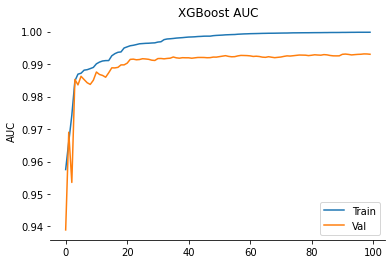

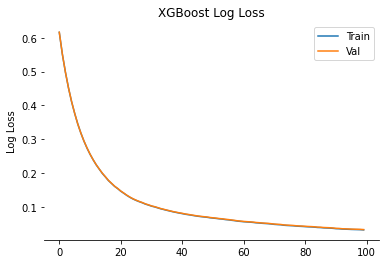

In [23]:
plot_xgb_learning_curve(xgb_model_baseline, 'auc', 'AUC', 'XGBoost AUC')
plot_xgb_learning_curve(xgb_model_baseline, 'logloss', 'Log Loss', 'XGBoost Log Loss')

The baseline model works really well for a first try. There are no signal of overfitting. Instead we might push our model a little further to see if we will get better results.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45320
           1       0.24      0.86      0.38        76

    accuracy                           1.00     45396
   macro avg       0.62      0.93      0.69     45396
weighted avg       1.00      1.00      1.00     45396

Balanced Accuracy: 0.9253919496446323
Class 0 Accuracy: 1.00
Class 1 Accuracy: 0.86


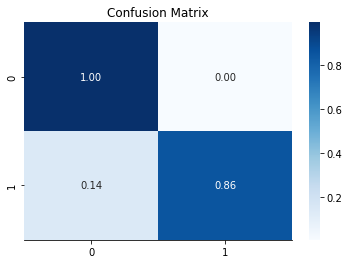

Threshold value is: 1


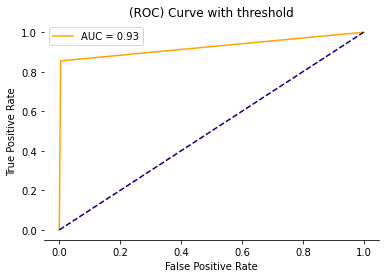

Threshold value is: 0.07095699


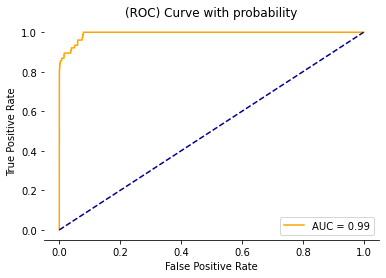

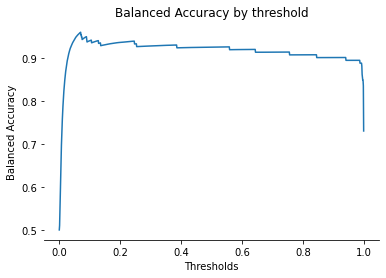

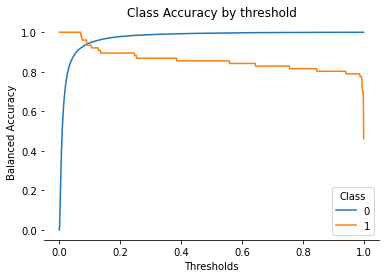

In [24]:
plot_model_metrics(xgb_model_baseline, X_val, y_val)

Those metrics are calculated with a threshold of 0.5. But looking at the 'Class Accuracy by threshold', for our base line, it will be best if the threshold was a little bit lower than 0.6.

For model improvment we must search for the best paramters. Since we do not have a lot of time for search all those result our aproach will be using Random Search, getting a higher search space with less computing time.

In [25]:
param_dist = {
    'n_estimators': np.arange(100,400,2),
    'max_depth': np.arange(1,10,1),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'reg_alpha': np.arange(0, 1.25, 0.25),
    'reg_lambda': np.arange(0, 1.25, 0.25)
}

In [26]:
param_dist

{'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
 'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'n_estimators': array([100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124,
        126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150,
        152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176,
        178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202,
        204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228,
        230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254,
        256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280,
        282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306,
        308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332,
        334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358,
        360, 362, 364, 366, 368, 370,

In [27]:
X_grid = df_train.copy()

X_grid['Amount'] = scaler.fit_transform(X_grid[['Amount']].values)

#Remove Time feature
X_grid = X_grid.drop(['Time'], axis=1)

y_grid = X_grid.pop('Class')

In [28]:
xgb_grid_search = xgb.XGBClassifier(objective='binary:logistic')
xgb_grid_result = RandomizedSearchCV(
    xgb_grid_search, 
    param_dist,
    scoring = 'roc_auc',
    n_iter = 40,
    n_jobs=-1, 
    verbose=2, 
    cv=StratifiedKFold(n_splits=3)
).fit(X_grid, y_grid)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [30]:
xgb_grid_result.best_params_

{'colsample_bylevel': 0.8999999999999999,
 'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 180,
 'reg_alpha': 0.75,
 'reg_lambda': 0.25}

In [31]:
xgb_model_best = xgb.XGBClassifier(
    colsample_bylevel = 0.8999999999999999,
    colsample_bytree = 0.7,
    learning_rate = 0.1,
    max_depth = 6,
    n_estimators = 180,
    reg_alpha = 0.75,
    reg_lambda = 0.25
)

eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_model_best.fit(X_train, y_train, eval_metric=["auc","logloss"], eval_set=eval_set, verbose=True, sample_weight=w_array)

[0]	validation_0-auc:0.980527	validation_0-logloss:0.610902	validation_1-auc:0.910182	validation_1-logloss:0.611228
[1]	validation_0-auc:0.988801	validation_0-logloss:0.540852	validation_1-auc:0.935472	validation_1-logloss:0.54034
[2]	validation_0-auc:0.994217	validation_0-logloss:0.478991	validation_1-auc:0.948389	validation_1-logloss:0.479381
[3]	validation_0-auc:0.996767	validation_0-logloss:0.4264	validation_1-auc:0.951712	validation_1-logloss:0.426966
[4]	validation_0-auc:0.996937	validation_0-logloss:0.382361	validation_1-auc:0.947677	validation_1-logloss:0.38234
[5]	validation_0-auc:0.997078	validation_0-logloss:0.343616	validation_1-auc:0.946991	validation_1-logloss:0.343557
[6]	validation_0-auc:0.998688	validation_0-logloss:0.30808	validation_1-auc:0.954851	validation_1-logloss:0.308745
[7]	validation_0-auc:0.99887	validation_0-logloss:0.279703	validation_1-auc:0.947843	validation_1-logloss:0.27999
[8]	validation_0-auc:0.998861	validation_0-logloss:0.252397	validation_1-auc:0.

XGBClassifier(colsample_bylevel=0.8999999999999999, colsample_bytree=0.7,
              max_depth=6, n_estimators=180, reg_alpha=0.75, reg_lambda=0.25)

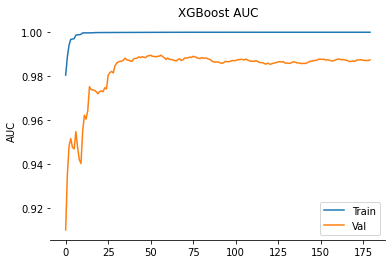

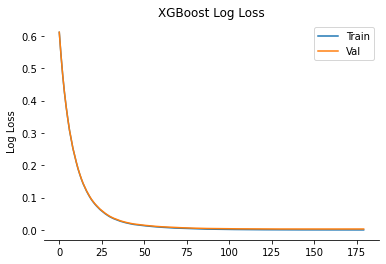

In [32]:
plot_xgb_learning_curve(xgb_model_best, 'auc', 'AUC', 'XGBoost AUC')
plot_xgb_learning_curve(xgb_model_best, 'logloss', 'Log Loss', 'XGBoost Log Loss')

As we can see our model has improved it's learning curve, which get lower much faster than the baseline model, reaching a plateau.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45320
           1       0.93      0.82      0.87        76

    accuracy                           1.00     45396
   macro avg       0.96      0.91      0.93     45396
weighted avg       1.00      1.00      1.00     45396

Balanced Accuracy: 0.9078395735587866
Class 0 Accuracy: 1.00
Class 1 Accuracy: 0.82


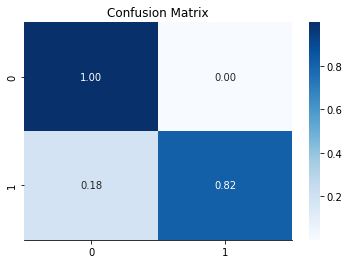

Threshold value is: 1


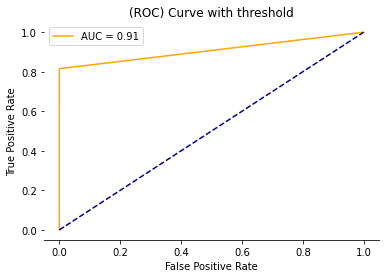

Threshold value is: 0.00049952127


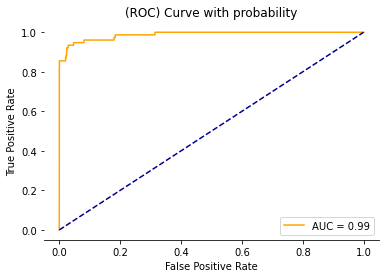

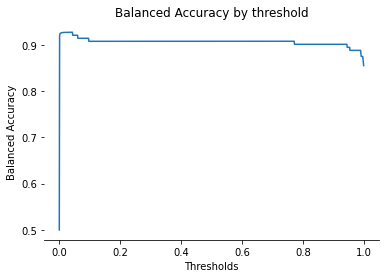

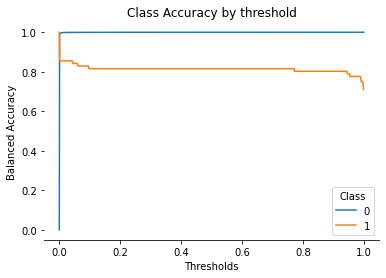

In [33]:
plot_model_metrics(xgb_model_best, X_val, y_val)

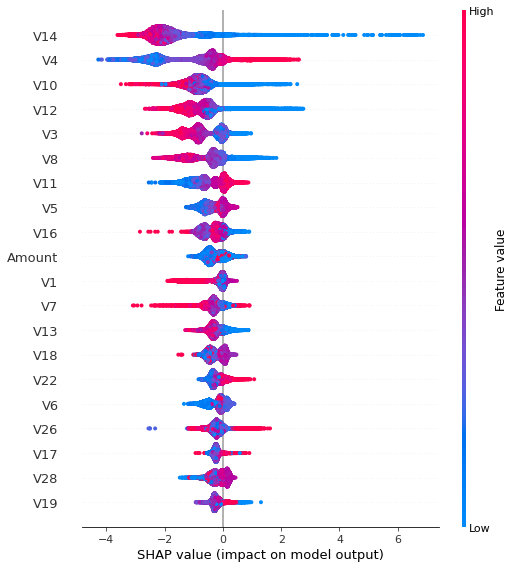

In [41]:
import shap
shap_values = shap.TreeExplainer(xgb_model_best).shap_values(X_val)
shap.summary_plot(shap_values, X_val)

The accuracy of our interest class (1) has also greatly increased from 0.24 to 0.93. Furthermore, we have a more uniform line in the threshold curve of our class, demonstrating a better generalization of the model.

As XGBoost bring complexity to the table, a better way ti understand the model behavior is with shap. It provides a top down feature importance on the left side. In the X axis we can see how much each class has been impacted by each feature, and at last but not least the color will indicate the feature value (closer to blue will be a lower value, and nearest to red it will imply in a higher value).

Now let's see the results of our best model in the test set.

In [34]:
X_test = df_test.copy()
X_test = X_test.drop(['Time'], axis=1)
X_test['Amount'] = scaler.transform(X_test[['Amount']].values)
y_test = X_test.pop('Class')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.91      0.79      0.85        95

    accuracy                           1.00     56746
   macro avg       0.96      0.89      0.92     56746
weighted avg       1.00      1.00      1.00     56746

Balanced Accuracy: 0.8946750603185338
Class 0 Accuracy: 1.00
Class 1 Accuracy: 0.79


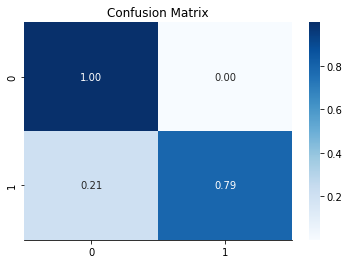

Threshold value is: 1


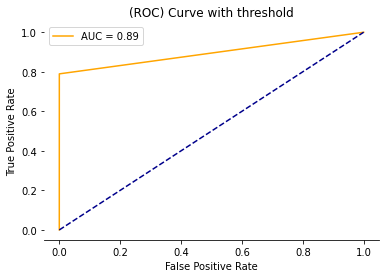

Threshold value is: 0.0004524299


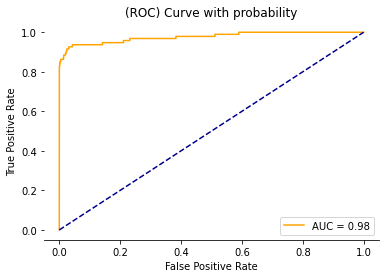

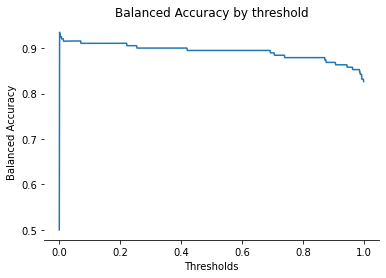

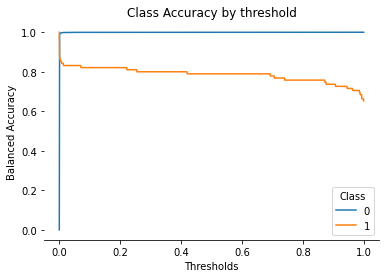

In [35]:
plot_model_metrics(xgb_model_best, X_test, y_test)

We sucessfully created a model that has good generalization based on the test inference having nice threshold point near 0.63. 

In the metrics themselves we had a very small variation (approximately 0.03) in the main metrics such as balanced accuracy (from 0.907 - to 0.894), accuracy of the class of interece (from 0.82 - to 0.79) and precision (from 0.93 - to 0.91).